# Numerical modelling of synaptic transmission in 3D

In [1]:
%matplotlib notebook 
import numpy as np
import matplotlib.pyplot as plt
from getCylinder2 import GetCylinder

from matplotlib.animation import FuncAnimation
from IPython.display import HTML, clear_output

In [2]:
%%html 
<style>
.output_wrapper button.btn.btn-default, .output_wrapper .ui-dialog-titlebar {
    display: none;
} </style>

In [3]:
#Constants, for now set everything equal to one

## 3D
* Build mass matrix and load vector
* Need new mesh generator, new matrix and load vector builder, otherwise the same
* Solve system of ODE's
* More complicated animation

In [4]:
N = 10
n = 4
p, tri, bottom, middle, top = GetCylinder(N,n)

<IPython.core.display.Javascript object>


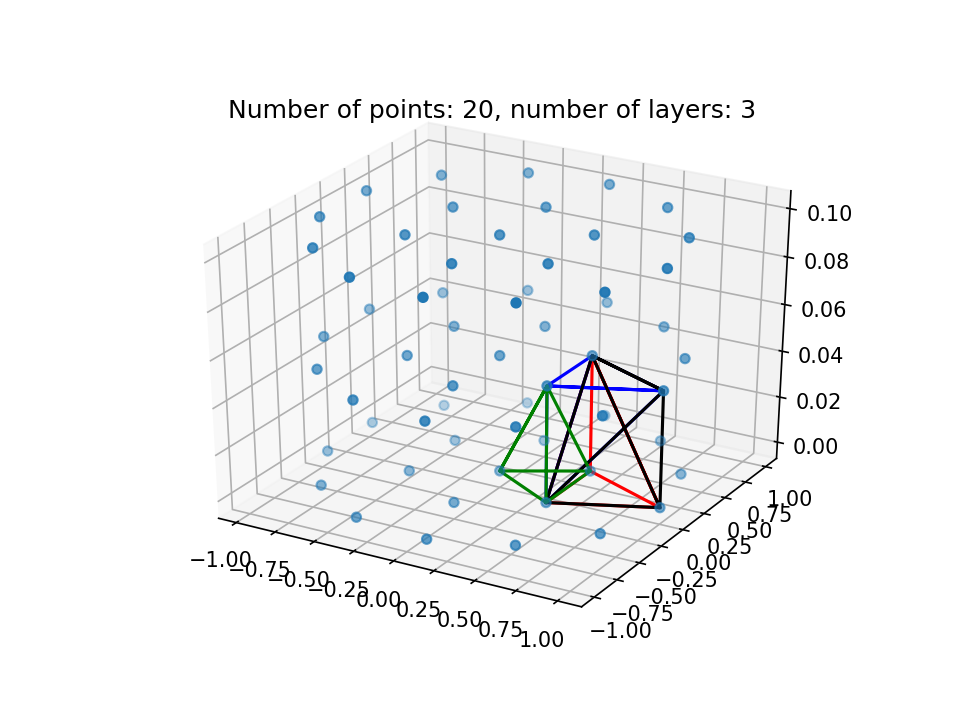

In [5]:
ax = plt.axes(projection='3d')

ax.scatter3D(p[:,0], p[:,1], p[:,2], cmap='Greens');

In [6]:
def getVolume(p1, p2, p3, p4):
    v1 = p2 - p1
    v2 = p3 - p1
    v3 = p4 - p1
    volume = 1/6 * np.abs(v1 @ np.cross(v2, v3))
    return volume

In [8]:
def plotMeshProper(N, n):
    p, tri, bottom, middle, top = GetCylinder(N,n)
    ax = plt.axes(projection='3d')
    x = p[:, 0].flatten(); y = p[:, 1].flatten(); z = p[:,2].flatten()
    print(tri.shape)
    i = 0
    for elem in tri:
        elem_ = np.array([elem[0], elem[1], elem[2], elem[3], elem[0], elem[2], elem[3], elem[1]])
        colors = ['red', 'blue', 'black', 'green']
        if i < 4:
            ax.plot3D(x[elem_], y[elem_], z[elem_], color = colors[i])
        #else:
        #    ax.plot3D(x[elem_], y[elem_], z[elem_], color = 'black')
        i+=1    
    ax.scatter3D(x, y, z)
    
    ax.set_title(f"Number of points: {N}, number of layers: {n}")

In [9]:
plotMeshProper(20, 3)

(150, 4)


In [10]:
# Quadrature points and weights for gaussian integration, 27-point rule
def GaussianQuadrature3D(p1, p2, p3, p4, f):
    # map to reference
    # p1 -> 0,0,0, p2-> 1,0,0, p3-> 0,1,0, p4 -> 0,0,1
    # scale weights to volume
    #Calculate volume:
    # Reference 1/(6*np.sqrt(2))
    # Original 
    
    A = np.zeros((3,3))
    A[:,0] = p2 - p1
    A[:,1] = p3 - p1
    A[:,2] = p4 - p1
                                            
    gp = np.array([[0.112701654, 0.2123405382, 0.294997790],
                   [0.5, 0.590533135, 0.652996233],
                   [0.887298346, 0.911412040, 0.927005975]])
    
    
    gw = np.array([[0.277777778, 0.069826979, 0.029950703],
                   [0.444444444, 0.229241106, 0.146246269],
                   [0.277777778, 0.200931913, 0.157136361]])
    
    v1 = p2 - p1
    v2 = p3 - p1
    v3 = p4 - p1
    volume = 1/6 * np.abs(v1 @ np.cross(v2, v3))
    gw = gw * (volume * 6)**(1/3)
    
    I = 0
    for i in range(3):
        for j in range(3):
            for k in range(3):
                mapped = A@np.array([gp[i,2]*gp[j,1]*gp[k,0],gp[i,2]*gp[j,1]*(1-gp[k,0]),gp[i,2]*(1-gp[j,1])]) + p1
                I += gw[i,2]*gw[j,1]*gw[k,0]*f(mapped[0], mapped[1], mapped[2])
    return I

In [11]:
p1 = np.array([0,0,0])
p2 = np.array([1,0,0])
p3 = np.array([0,1,0])
p4 = np.array([0,0,1])

print(GaussianQuadrature3D(p1, p2, p3, p4, lambda x,y,z : x*y*z))

0.0013888888393469604


In [12]:
def assembleAh_k(p, elem):
    M = np.ones((4,4))
    index = np.array([elem[0], elem[1], elem[2], elem[3]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    M[:,3] = points[:,2]
    C_1 = np.linalg.solve(M, np.array([1,0,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1,0]))
    C_4 = np.linalg.solve(M, np.array([0,0,0,1]))
    C = np.array([C_1, C_2, C_3, C_4])
    
    Ah_k = np.zeros((4,4))
    Area = GaussianQuadrature3D(points[0], points[1], points[2], points[3], lambda x,y,z : 1)
    for alpha in range(4):
        for beta in range(4):
            Ah_k[alpha,beta] = Area * (C[alpha,1] * C[beta,1] + C[alpha,2] * C[beta,2] + C[alpha,3] * C[beta,3])
    return Ah_k

def assembleAh(N, p, tri):
    Ah = np.zeros((N,N))
    for k in range(len(tri)):
        Ah_k = assembleAh_k(p, tri[k])
        for alpha in range(4):
            i = tri[k,alpha]
            for beta in range(4):
                j = tri[k,beta]
                Ah[i,j] += Ah_k[alpha, beta]
    return Ah
                      
def assembleFh_k(p, elem, f):
    M = np.ones((4,4))
    index = np.array([elem[0], elem[1], elem[2], elem[3]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    M[:,3] = points[:,2]
    C_1 = np.linalg.solve(M, np.array([1,0,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1,0]))
    C_4 = np.linalg.solve(M, np.array([0,0,0,1]))
    C = np.array([C_1, C_2, C_3, C_4])
    
    Fh_k = np.zeros(4)
    for alpha in range(4):
        H = lambda x,y,z : C[alpha,0] + C[alpha,1] * x + C[alpha,2] * y + C[alpha,3] * z
        Hf = lambda x,y,z : H(x,y,z) * f(x,y,z)
        Fh_k[alpha] = GaussianQuadrature3D(points[0], points[1], points[2], points[3], Hf)
    return Fh_k

def assembleFh(N, p, tri, f):
    Fh = np.zeros(N)
    for k in range(len(tri)):
        Fh_k = assembleFh_k(p, tri[k], f)
        for alpha in range(4):
            i = tri[k, alpha]
            Fh[i] += Fh_k[alpha]
    return Fh

def assembleMh_k(p,elem):
    M = np.ones((4,4))
    index = np.array([elem[0], elem[1], elem[2], elem[3]])
    points = p[index]
    M[:,1] = points[:,0]
    M[:,2] = points[:,1]
    M[:,3] = points[:,2]
    C_1 = np.linalg.solve(M, np.array([1,0,0,0]))
    C_2 = np.linalg.solve(M, np.array([0,1,0,0]))
    C_3 = np.linalg.solve(M, np.array([0,0,1,0]))
    C_4 = np.linalg.solve(M, np.array([0,0,0,1]))
    C = np.array([C_1, C_2, C_3, C_4])
    
    Mh_k = np.zeros((4,4))
    for alpha in range(4):
        for beta in range(4):
            Ha = lambda x,y,z: C[alpha,0] + C[alpha,1] * x + C[alpha,2] * y + C[alpha,3] * z
            Hb = lambda x,y,z: C[beta,0] + C[beta,1] * x + C[beta,2] * y + C[beta,3] * z
            Hf = lambda x,y,z: Ha(x,y,z) * Hb(x,y,z)
            Mh_k[alpha,beta] = GaussianQuadrature3D(points[0], points[1], points[2], points[3], Hf)
    return Mh_k
    

def assembleMh(N, p, tri):
    Mh = np.zeros((N,N))
    for k in range(len(tri)):
        Mh_k = assembleMh_k(p, tri[k])
        for alpha in range(4):
            i = tri[k,alpha]
            for beta in range(4):
                j = tri[k,beta]
                Mh[i,j] += Mh_k[alpha, beta]
    return Mh

In [42]:
# A does not depend on the timestep so it can be created in the beginning.
N = 64
n = 10

p, tri, bottom, middle, top = GetCylinder(N, n)

In [44]:
N = 64
n = 10
# Assemble matrices and load vector
A_ = assembleAh(N*n, p, tri)

M_ = assembleMh(N*n, p, tri)
F_ = assembleFh(N*n, p, tri, lambda x,y,z : 0)

# Removing bottom 
keep = np.array([i for i in range(len(A_)) if i not in bottom])
print(keep)
ixy = np.ix_(keep, keep)
A = A_[ixy]
M = M_[ixy]
F = F_[keep]
p = p[keep]
I = np.identity(len(A))

# Initial conditions
r = np.zeros(F.shape)
n = np.zeros(F.shape)
r[bottom] = np.ones(len(bottom)) * 0.01
n[-int(N/2)] = 1#np.ones(len(top))

# Neumann boundary conditions in F, should be zero for the first time step
# This needs to be replaced by surface integral
#F[bottom] = - r[bottom]*n[bottom] + (0.01-r[bottom])
#print(np.linalg.cond(M))
#print(np.linalg.cond(A))

[ 64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79  80  81
  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99
 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117
 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135
 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153
 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171
 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189
 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207
 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225
 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243
 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261
 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279
 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296 297
 298 299 300 301 302 303 304 305 306 307 308 309 31

In [45]:
Minv = np.linalg.inv(M)
print(2/np.max(np.linalg.eigvalsh(Minv@A)))
nArray = [n]
rArray = [r]

LinAlgError: Singular matrix

In [34]:
# Forward Euler part 
nArray = [n]
dt = 0.00000001 #1.e-11
nSteps = 1000 #int(0.22 / 1.e-11)

for i in range(1,nSteps):
    #M(N_-N)/dt = AN_ + F or M(N_-N)/dt = 1/2 (AN_ + F_ + AN + F) --- for simplicity we let F_ = F
    #-> N_ = np.linalg.solve(M, dtAN_ + dtF + MN)
    # or (M - 1/2 dt A)N_  = (M + 1/2 dt A)N + F
    #n_ = (I - dt * Minv@A)@nArray[i-1] #+ dt*Minv@F
    #n_ = np.linalg.solve(1/dt * M + 1/2 * A, (1/dt * M - 1/2 * A) @ nArray[i-1])
    #n_ = np.linalg.solve(M-1/2 * dt * A, (M + 1/2 * dt * A)@nArray[i-1])
    
    n_ = np.linalg.solve(M-1/2 *  dt * A, M@nArray[i-1])
    
    #r_ = rArray[i-1] + dt*rArray[i-1]*nArray[i-1] + dt*(0.01-rArray[i-1])
    #F[bottom] = - r[bottom]*n[bottom] + (0.01-r[bottom])
    nArray.append(n_)
    #rArray.append(r_)
    #print(np.max(n_[bottom]))

In [36]:
for i in range(10):
    print(np.sum(nArray[i*90]))

1.0
1.0039439243353008
1.0077626103155302
1.0114505216262646
1.0150019547699571
1.018411034408616
1.0216717085778435
1.0247777437686336
1.027722719873241
1.0305000249912513


<IPython.core.display.Javascript object>


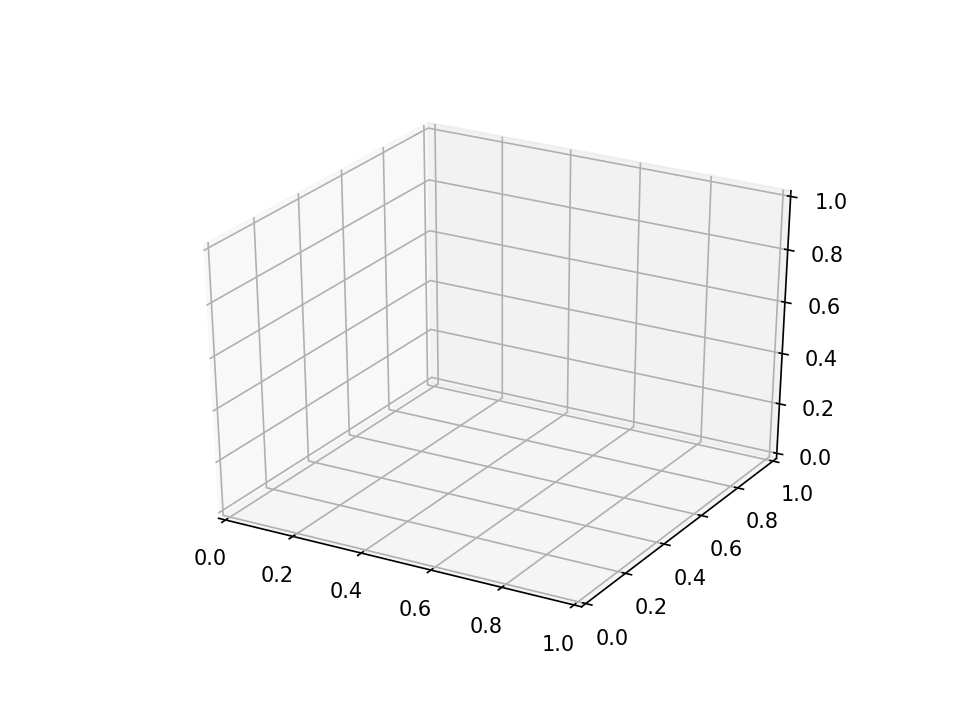

ValueError: 'c' argument has 64 elements, which is inconsistent with 'x' and 'y' with size 640.

In [38]:
plt.figure()
ax = plt.axes(projection='3d')
test = np.linspace(0,1,len(p[:,0]))
ax.scatter3D(p[:,0], p[:,1], p[:,2], c = nArray[99])
plt.show()

In [ ]:
def animate_diffusion(nArray, fps, step, p, steps):
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    
    #Method to change the contour plot
    def animate(i):
        ax.clear()
        ax.scatter3D(p[:,0], p[:,1], p[:,2], c = nArray[i*step])
        ax.set_title(f"diffusion after {i*step} steps, i = {i}");

    ani = FuncAnimation(fig, animate, frames = steps-1, repeat = False)
    #return HTML(ani.to_jshtml())
    return ani

def animate_func(p, nArray, steps = 100, duration = 5):
    step = len(nArray)//steps
    plt.rcParams["figure.figsize"] = [5.00, 5.00]
    plt.rcParams["figure.autolayout"] = True
    fps = steps / duration
    animations = animate_diffusion(nArray, fps,step, p, steps)
    
    return animations

In [ ]:
%%capture
ani = animate_func(p, nArray, 20)

In [ ]:
display(HTML(ani.to_jshtml()))

### Trying diffusion only with Dirichlet Boundary conditions

In [ ]:
# A does not depend on the timestep so it can be created in the beginning.
N = 64
n = 10

p, tri, bottom, middle, top = GetCylinder(N, n)

In [ ]:
N = 64
n = 10
# Assemble matrices and load vector
A = assembleAh(N*n, p, tri)

M = assembleMh(N*n, p, tri)
F = assembleFh(N*n, p, tri, lambda x,y,z : 0)

arg = (bottom, middle, top)
boundary = np.concatenate((bottom, middle, top))

nint = [i for i in range(len(A)) if i not in boundary] #Interior nodes
index = np.ix_(nint, nint)

A_tilde = A[index]
M_tilde = M[index]
I = np.identity(len(M_tilde))
F_tilde = F[nint]


# Initial conditions
r = np.zeros(F_tilde.shape)
n = np.zeros(F_tilde.shape)
#r[bottom] = np.ones(len(bottom)) * 0.01
n[[len(n)//2, len(n)//2 + 1, len(n)//2-1]] = 1#np.ones(len(top))

# Neumann boundary conditions in F, should be zero for the first time step
# This needs to be replaced by surface integral
#F[bottom] = - r[bottom]*n[bottom] + (0.01-r[bottom])
#print(np.linalg.cond(M))
#print(np.linalg.cond(A))

#Minv = np.linalg.inv(M)
nNew = np.zeros(F.shape)
nNew[nint] = n
nArray = [nNew]
rArray = [r]

# Forward Euler part 
nSteps = 100
dt = 0.001/nSteps
for i in range(1,nSteps):
    #M(N_-N)/dt = AN_ + F or M(N_-N)/dt = 1/2 (AN_ + F_ + AN + F) --- for simplicity we let F_ = F
    #-> N_ = np.linalg.solve(M, dtAN_ + dtF + MN)
    # or (M - 1/2 dt A)N_  = (M + 1/2 dt A)N + F
    #n_ = (I - dt * Minv@A)@nArray[i-1] #+ dt*Minv@F
    #n_ = np.linalg.solve(1/dt * M + 1/2 * A, (1/dt * M - 1/2 * A) @ nArray[i-1])
    n_ = np.linalg.solve(M_tilde-1/2 * dt * A_tilde, (M_tilde + 1/2 * dt * A_tilde)@nArray[i-1][nint] + F_tilde)
    #r_ = rArray[i-1] + dt*rArray[i-1]*nArray[i-1] + dt*(0.01-rArray[i-1])
    #F[bottom] = - r[bottom]*n[bottom] + (0.01-r[bottom])
    nNew = np.zeros(F.shape)
    nNew[nint] = n_
    nArray.append(nNew)
    #rArray.append(r_)
    #print(np.max(n_[bottom]))

In [ ]:
%%capture
ani = animate_func(p, nArray, 20)

In [ ]:
display(HTML(ani.to_jshtml()))